# XGBOOST MODELS FOR 289:10,000 RATIO
> **Undersampling the inactive class only**
>
> MinMaxScalar will not be used

## IMPORTING LIBRARIES AND DATA

In [1]:
# the big three
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# training algorithms
import xgboost

# resampling algorithms
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# importing other libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

# importing metrics 
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, roc_curve, auc

In [2]:
# read dataset into dataframe
df = pd.read_csv("../../data/final.csv")
df.head()

D001  D002  D003  D004  D005  D006  D007  D008  D009  D010  ...  D769  \
0     2     0     0     1     4     0     0     0     0     0  ...     0   
1     1     0     0     2     1     0     0     0     0     0  ...     0   
2     1     0     0     0     2     0     0     0     0     0  ...     0   
3     2     0     0     1     3     0     0     0     0     0  ...     0   
4     1     0     0     0     2     0     0     0     0     0  ...     0   

   D770  D771  D772  D773     D774      D775      D776     D777  Activity  
0     1     0     0     0  5.45943 -0.367670  0.363636  4.29650         0  
1     1     0     0     0  5.08746 -0.772128  0.240000  2.31134         0  
2     0     0     0     0  4.70044 -0.295978  0.300000  1.67610         0  
3     1     1     0     0  5.49185 -0.357977  0.352941  2.63932         0  
4     0     0     0     0  4.64386 -0.274183  0.315789  1.41996         0  

[5 rows x 778 columns]

In [3]:
# checking dimension of dataset
df.shape

(195244, 778)

0    194888
1       356
Name: Activity, dtype: int64


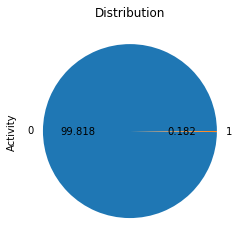

In [4]:
# divide dataframe into features, X and target y
X = df.drop(['Activity'],axis=1)
y = df['Activity']

# checking class distribution
print(y.value_counts())

# visualizing class distribution
ax = y.value_counts().plot(kind = 'pie', autopct = '%.3f')
ax.set_title("Distribution");

## DIVIDING INTO TRAIN AND TEST DATASET

The training and test data have the following dimensions:
(156195, 777)(39049, 777)
The class distribution of the train data:
0    155906
1       289
Name: Activity, dtype: int64


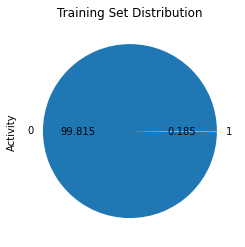

In [5]:
# dividing datasets into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# checking dimensions of train and test dataset
print("The training and test data have the following dimensions:\n{}{}".format(X_train.shape, X_test.shape))

# checking class distribution of train dataset
print("The class distribution of the train data:\n{}".format(y_train.value_counts()))

# visualizing class distribution of train dataset
ax = y_train.value_counts().plot(kind = 'pie', autopct = '%.3f')
ax.set_title("Training Set Distribution");

##  REMOVING LOW VARIANCE FEATURES
> The variance threshold function will remove columns that dont meet a certain threshold. This is done to improve model performance
>
> There are two different thresholds for this. Use the second one only when MinMaxScalar was used. You can use only one threshold

In [6]:
vt = VarianceThreshold(threshold=(.8 * (1 - .8)))

# Fit
_ = vt.fit(X_train)

# Get the mask
mask = vt.get_support()

# Subset the DataFrame
X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]

X_train.shape, X_test.shape

((156195, 359), (39049, 359))

> The number of rows in the dataset remain the same however the number of columns have reduced

## XGBOOST MODEL TRAINING
> For this section, the model is trained on either unsampled data or resampled data.

## RESAMPLING USING RUS AND SMOTE
> The dataset is resampled using either one or a combination of random undersampler and smote with different ratios. Meaning, you can use undersampling and skip oversampling or vice versa or use both
>
> **THIS STEP SHOULD BE SKIPPED IF NO RESAMPLING WILL BE DONE**

### UNDERSAMPLING

In [7]:
rus = RandomUnderSampler(sampling_strategy=0.0289)
X_train, y_train = rus.fit_resample(X_train, y_train)

# checking class distribution of further resampled dataset
print(y_train.value_counts())

0    10000
1      289
Name: Activity, dtype: int64


**Visualizing distribution of final resampled dataset**


In [8]:
# checking class distribution of further resampled dataset
print(y_train.value_counts())

ax = y_train.value_counts().plot(kind = 'pie', autopct = '%.3f')
ax.set_title("Distribution of classes in Resampled Data");

0    10000
1      289
Name: Activity, dtype: int64


## TRAINING MODELS

In [9]:
# creating model object
clf = xgboost.XGBClassifier(use_label_encoder=False)

# training model
clf.fit(X_train, y_train)

[08:23:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## PREDICTIONS

In [10]:
# predicting on train dataset
train_predictions = clf.predict(X_train)    

# predicting on test dataset
test_predictions = clf.predict(X_test)

> If the performance of the model on the training dataset is significantly better than the performance on the test dataset, then the model may have overfit the training dataset.

## CHECKING METRICS
> The metrics will be checked for both the training data and the tes dataset
>
> For the confusion matrix: <br>
> True Negative (Top-Left Quadrant)<br>
False Positive (Top-Right Quadrant)<br>
False Negative (Bottom-Left Quadrant)<br>
True Positive (Bottom-Right Quadrant)<br>

### TRAINING DATA

Accuracy Score:  1.0
Precision Score:  1.0
Recall Score:  1.0
F1 Score:  1.0
MCC:  1.0
AUROC:  1.0


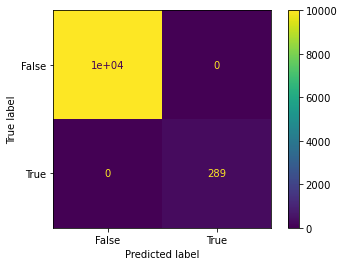

In [11]:
accuracy_test = accuracy_score(y_train, train_predictions)
precision = precision_score(y_train, train_predictions)
recall = recall_score(y_train, train_predictions)
f1 = f1_score(y_train, train_predictions)
mcc = matthews_corrcoef(y_train, train_predictions)

pred_prob = clf.predict_proba(X_train)[:,1]
auroc = roc_auc_score(y_train, pred_prob)                   

print("Accuracy Score: ", accuracy_test)
print("Precision Score: ", precision)
print("Recall Score: ", recall)
print("F1 Score: ", f1)
print("MCC: ", mcc)
print("AUROC: ", auroc)

cm = confusion_matrix(y_train, train_predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

### TEST DATA

Accuracy Score:  0.9993853875899511
Precision Score:  0.9215686274509803
Recall Score:  0.7014925373134329
F1 Score:  0.7966101694915254
MCC:  0.8037532243712763
AUROC:  0.9960123195014614


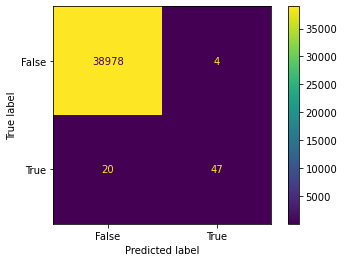

In [12]:
accuracy_test = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)

pred_prob = clf.predict_proba(X_test)
auroc = roc_auc_score(y_test, pred_prob[:,1])

print("Accuracy Score: ", accuracy_test)
print("Precision Score: ", precision)
print("Recall Score: ", recall)
print("F1 Score: ", f1)
print("MCC: ", mcc)
print("AUROC: ", auroc)

cm = confusion_matrix(y_test, test_predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

#### PLOTTING THE AUROC CURVE
> This is done for only the test data

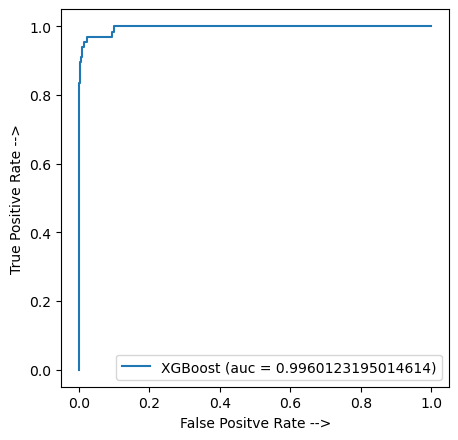

In [13]:
fpr, tpr, threshold = roc_curve(y_test, pred_prob[:, 1])
auc_score = auc(fpr, tpr)

plt.figure(figsize = (5, 5), dpi = 100)
plt.plot(fpr, tpr, label = 'XGBoost (auc = {})' .format(auc_score))
plt.xlabel('False Positve Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()
plt.show()

> Is the curve consistent to the auroc value obtained previously

In [ ]:
# from sklearn.model_selection import cross_val_score
# from numpy import mean

# scores = cross_val_score(knn, X, y, scoring = 'roc_auc', cv = 2)
# print('Mean ROC AUC: %.5f' % mean(scores))